In [ ]:
import os
from utils import *
import utils
import torchvision.models as models
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR
from copy import deepcopy
import argparse


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--seeds',          type=int,       default=[2023, 2024, 2025])
parser.add_argument('--num_epochs',     type=int,       default=200)
parser.add_argument('--lr',             type=float,     default=0.1)
parser.add_argument('--dataset',        type=str,       default='cifar100')
parser.add_argument('--batch_size',     type=int,       default=512)
parser.add_argument('--model_name',     type=str,       default='resnet18')
parser.add_argument('--retrain',        type=bool,      default=False)
parser.add_argument('--unlearn_class',  type=list,      default=[65,80,51,28,85,97,67,86,19,32])
args = parser.parse_args("")

if args.dataset.lower() == 'fmnist':
    args.n_channels = 1
else:
    args.n_channels = 3

if args.dataset.lower() == 'cifar100':
    args.num_classes = 100
else:
    args.num_classes = 10

criterion = nn.CrossEntropyLoss()

In [3]:
arxiv_name = 'original_model_12-20-05-11'
train_loader, val_loader, test_loader = get_dataloader(args)
train_targets_list = np.array(train_loader.dataset.targets)[train_loader.sampler.indices]
unlearn_indices = np.where(np.isin(train_targets_list, args.unlearn_class))[0]

# conver to the original indices
unlearn_indices = train_loader.sampler.indices[unlearn_indices]

unlearn_sampler = torch.utils.data.SubsetRandomSampler(unlearn_indices)
unlearn_subset_loader = torch.utils.data.DataLoader(train_loader.dataset, 
                                                    batch_size=args.batch_size, 
                                                    sampler=unlearn_sampler)
remain_class = np.setdiff1d(np.arange(args.num_classes), args.unlearn_class)

remain_indices = np.where(~np.isin(train_targets_list, args.unlearn_class))[0]
remain_indices = train_loader.sampler.indices[remain_indices]

remain_sampler = torch.utils.data.SubsetRandomSampler(remain_indices)
remain_loader = torch.utils.data.DataLoader(train_loader.dataset, 
                                            batch_size=args.batch_size, 
                                            sampler=remain_sampler)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
Acc_r, Acc_f = np.zeros((2,3)), np.zeros((2,3))

for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    Acc_f[0][i], Acc_r[0][i] = test_by_class(model, test_loader, i=args.unlearn_class)

print('------------ Retrained model ------------')
for i in range(3):
    model_r = get_model(args)
    model_r.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/retrain_model_12-20-03-04_{args.seeds[i]}.pth'))
    Acc_f[1][i], Acc_r[1][i] = test_by_class(model_r, test_loader, i=args.unlearn_class)

print(f'Original model Acc_f: {100*Acc_f[0].mean():.2f} \pm {100*Acc_f[0].std():.2f}')
print(f'Original model Acc_r: {100*Acc_r[0].mean():.2f} \pm {100*Acc_r[0].std():.2f}')

print(f'Retrained model Acc_f: {100*Acc_f[1].mean():.2f} \pm {100*Acc_f[1].std():.2f}')
print(f'Retrained model Acc_r: {100*Acc_r[1].mean():.2f} \pm {100*Acc_r[1].std():.2f}')
 

0.9100, 0.8300, 0.6100, 0.6500, 0.6700, 0.7900, 0.8200, 0.7700, 0.9000, 0.8600, 0.5200, 0.5000, 0.7900, 0.7400, 0.7300, 0.7600, 0.7500, 0.9000, 0.5900, [0.7100], 0.8600, 0.9000, 0.7700, 0.8000, 0.8200, 0.5700, 0.7700, 0.6100, [0.8100], 0.7500, 0.6600, 0.7500, [0.6900], 0.6700, 0.8200, 0.4400, 0.8600, 0.7600, 0.7300, 0.8900, 0.6300, 0.9000, 0.8000, 0.8400, 0.5100, 0.6400, 0.5100, 0.7100, 0.9400, 0.8700, 0.5600, [0.7300], 0.6600, 0.9100, 0.8100, 0.5200, 0.8700, 0.8200, 0.8700, 0.7000, 0.8900, 0.7500, 0.7900, 0.7000, 0.5900, [0.6200], 0.8300, [0.7100], 0.9400, 0.8300, 0.7500, 0.7900, 0.4700, 0.6400, 0.5800, 0.9000, 0.9200, 0.7000, 0.7100, 0.8200, [0.6000], 0.7700, 0.9200, 0.7200, 0.6700, [0.8500], [0.7500], 0.9000, 0.8500, 0.8900, 0.8400, 0.8400, 0.6700, 0.5600, 0.9300, 0.7400, 0.6700, [0.8100], 0.5500, 0.7100, Acc_f: 0.7280, Acc_r: 0.7491
0.8800, 0.8700, 0.6700, 0.6100, 0.7100, 0.8000, 0.8400, 0.7900, 0.8600, 0.8600, 0.4800, 0.4300, 0.8300, 0.7000, 0.7300, 0.8100, 0.8000, 0.8400, 0.6800,

# Random label

In [24]:
Acc_r, Acc_f = np.zeros(3), np.zeros(3)
for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    sgd_mr_model = deepcopy(model)
    test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)

    optimizer = torch.optim.SGD(sgd_mr_model.parameters(), lr=0.0001)
    sgd_mr_model.train()
    for m in sgd_mr_model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()

    for ep in range(20):
        for batch, (x, y) in enumerate(unlearn_subset_loader):
            x = x.cuda()
            y = torch.from_numpy(np.random.choice(remain_class, size=x.shape[0])).cuda()
            pred_y = sgd_mr_model(x)
            loss = criterion(pred_y, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('[train] epoch {}, batch {}, loss {}'.format(ep, batch, loss))
        Acc_r[i], Acc_f[i] = test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)

0.9100, 0.8300, 0.6100, 0.6500, 0.6700, 0.7900, 0.8200, 0.7700, 0.9000, 0.8600, 0.5200, 0.5000, 0.7900, 0.7400, 0.7300, 0.7600, 0.7500, 0.9000, 0.5900, 0.7100, 0.8600, 0.9000, 0.7700, 0.8000, 0.8200, 0.5700, 0.7700, 0.6100, 0.8100, 0.7500, 0.6600, 0.7500, 0.6900, 0.6700, 0.8200, 0.4400, 0.8600, 0.7600, 0.7300, 0.8900, 0.6300, 0.9000, 0.8000, 0.8400, 0.5100, 0.6400, 0.5100, 0.7100, 0.9400, 0.8700, 0.5600, 0.7300, 0.6600, 0.9100, 0.8100, 0.5200, 0.8700, 0.8200, 0.8700, 0.7000, 0.8900, 0.7500, 0.7900, 0.7000, 0.5900, 0.6200, 0.8300, 0.7100, 0.9400, 0.8300, 0.7500, 0.7900, 0.4700, 0.6400, 0.5800, 0.9000, 0.9200, 0.7000, 0.7100, 0.8200, 0.6000, 0.7700, 0.9200, 0.7200, 0.6700, 0.8500, 0.7500, 0.9000, 0.8500, 0.8900, 0.8400, 0.8400, 0.6700, 0.5600, 0.9300, 0.7400, 0.6700, 0.8100, 0.5500, 0.7100, Acc_f: 0.7280, Acc_r: 0.7491
[train] epoch 0, batch 9, loss 7.786905288696289
0.8900, 0.8200, 0.5200, 0.6400, 0.7300, 0.7800, 0.8200, 0.7200, 0.8900, 0.8500, 0.3400, 0.3900, 0.7600, 0.6400, 0.7100, 0.

In [30]:

Acc_f = 100*np.array([0.0200, 0.0070, 0.0070])
Acc_r = 100*np.array([0.2564, 0.2634, 0.2176])
print(f'Random label Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'Random label Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

Random label Acc_f: 1.13 \pm 0.61
Random label Acc_r: 24.58 \pm 2.01


In [5]:
Proj_mat_lst =[]
for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    test_by_class(model, test_loader, i=args.unlearn_class)
    
    feature_list = []
    merged_feat_mat = []
    for batch, (x, y) in enumerate(remain_loader):
        x = x.cuda()
        y = y.cuda()
        mat_list = get_representation_matrix(model, x, batch_list=[256]*30)
        break
    threshold = 0.99
    merged_feat_mat = update_GPM(mat_list, threshold, merged_feat_mat)
    proj_mat = [torch.Tensor(np.dot(layer_basis, layer_basis.transpose())) for layer_basis in merged_feat_mat]
    Proj_mat_lst.append(proj_mat)

0.9100, 0.8300, 0.6100, 0.6500, 0.6700, 0.7900, 0.8200, 0.7700, 0.9000, 0.8600, 0.5200, 0.5000, 0.7900, 0.7400, 0.7300, 0.7600, 0.7500, 0.9000, 0.5900, [0.7100], 0.8600, 0.9000, 0.7700, 0.8000, 0.8200, 0.5700, 0.7700, 0.6100, [0.8100], 0.7500, 0.6600, 0.7500, [0.6900], 0.6700, 0.8200, 0.4400, 0.8600, 0.7600, 0.7300, 0.8900, 0.6300, 0.9000, 0.8000, 0.8400, 0.5100, 0.6400, 0.5100, 0.7100, 0.9400, 0.8700, 0.5600, [0.7300], 0.6600, 0.9100, 0.8100, 0.5200, 0.8700, 0.8200, 0.8700, 0.7000, 0.8900, 0.7500, 0.7900, 0.7000, 0.5900, [0.6200], 0.8300, [0.7100], 0.9400, 0.8300, 0.7500, 0.7900, 0.4700, 0.6400, 0.5800, 0.9000, 0.9200, 0.7000, 0.7100, 0.8200, [0.6000], 0.7700, 0.9200, 0.7200, 0.6700, [0.8500], [0.7500], 0.9000, 0.8500, 0.8900, 0.8400, 0.8400, 0.6700, 0.5600, 0.9300, 0.7400, 0.6700, [0.8100], 0.5500, 0.7100, Acc_f: 0.7280, Acc_r: 0.7491
Threshold:  0.99
----------------------------------------
Gradient Constraints Summary
----------------------------------------
Layer 1 : 9/27
Layer 2 

In [6]:
for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    sgd_mr_model = deepcopy(model)
    test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)
    optimizer = torch.optim.SGD(sgd_mr_model.parameters(), lr=0.04)
    sgd_mr_model.train()
    for m in sgd_mr_model.modules():
        if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
            m.eval()

    for ep in range(10):
        for batch, (x, y) in enumerate(unlearn_subset_loader):
            x = x.cuda()
            y = torch.from_numpy(np.random.choice(remain_class, size=x.shape[0])).cuda()
            pred_y = sgd_mr_model(x)
            loss = criterion(pred_y, y)
            optimizer.zero_grad()
            loss.backward()
            kk = 0 
            for k, (m,params) in enumerate(sgd_mr_model.named_parameters()):
                if len(params.size())!=1:
                    sz =  params.grad.data.size(0)
                    params.grad.data = params.grad.data - torch.mm(params.grad.data.view(sz,-1),\
                                            Proj_mat_lst[i][kk].cuda()).view(params.size())
                    kk +=1
                elif len(params.size())==1:
                    params.grad.data.fill_(0)
            optimizer.step()
        print('[train] epoch {}, batch {}, loss {}'.format(ep, batch, loss))
        test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)

0.9100, 0.8300, 0.6100, 0.6500, 0.6700, 0.7900, 0.8200, 0.7700, 0.9000, 0.8600, 0.5200, 0.5000, 0.7900, 0.7400, 0.7300, 0.7600, 0.7500, 0.9000, 0.5900, [0.7100], 0.8600, 0.9000, 0.7700, 0.8000, 0.8200, 0.5700, 0.7700, 0.6100, [0.8100], 0.7500, 0.6600, 0.7500, [0.6900], 0.6700, 0.8200, 0.4400, 0.8600, 0.7600, 0.7300, 0.8900, 0.6300, 0.9000, 0.8000, 0.8400, 0.5100, 0.6400, 0.5100, 0.7100, 0.9400, 0.8700, 0.5600, [0.7300], 0.6600, 0.9100, 0.8100, 0.5200, 0.8700, 0.8200, 0.8700, 0.7000, 0.8900, 0.7500, 0.7900, 0.7000, 0.5900, [0.6200], 0.8300, [0.7100], 0.9400, 0.8300, 0.7500, 0.7900, 0.4700, 0.6400, 0.5800, 0.9000, 0.9200, 0.7000, 0.7100, 0.8200, [0.6000], 0.7700, 0.9200, 0.7200, 0.6700, [0.8500], [0.7500], 0.9000, 0.8500, 0.8900, 0.8400, 0.8400, 0.6700, 0.5600, 0.9300, 0.7400, 0.6700, [0.8100], 0.5500, 0.7100, Acc_f: 0.7280, Acc_r: 0.7491
[train] epoch 0, batch 8, loss 4.940127372741699
0.8800, 0.8800, 0.5900, 0.6700, 0.7000, 0.7500, 0.8300, 0.7800, 0.8900, 0.8500, 0.4000, 0.4000, 0.7900

In [8]:
Acc_f = 100*np.array([0.0040, 0.0050, 0.0000])
Acc_r = 100*np.array([0.7291, 0.7404, 0.7327])
print(f'Random label + subspace Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'Random label + subspace Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

Random label + subspace Acc_f: 0.30 \pm 0.22
Random label + subspace Acc_r: 73.41 \pm 0.47


In [7]:
def get_pseudo_label(args, model, x):
    masked_output = model(x)
    masked_output[:, args.unlearn_class] = -np.inf
    pseudo_labels = torch.topk(masked_output, k=1, dim=1).indices
    return pseudo_labels.reshape(-1)

for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    sgd_mr_model = deepcopy(model)
    test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)
    optimizer = torch.optim.SGD(sgd_mr_model.parameters(), lr=0.04)
    sgd_mr_model.train()
    for m in sgd_mr_model.modules():
        if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
            m.eval()

    model.eval()
    for ep in range(20):
        for batch, (x, y) in enumerate(unlearn_subset_loader):
            x = x.cuda()
            y = get_pseudo_label(args, model, x)
            pred_y = sgd_mr_model(x)
            loss = criterion(pred_y, y)
            optimizer.zero_grad()
            loss.backward()
            kk = 0 
            for k, (m,params) in enumerate(sgd_mr_model.named_parameters()):
                if len(params.size())!=1:
                    sz =  params.grad.data.size(0)
                    params.grad.data = params.grad.data - torch.mm(params.grad.data.view(sz,-1),\
                                            Proj_mat_lst[i][kk].cuda()).view(params.size())
                    kk +=1
                elif len(params.size())==1:
                    params.grad.data.fill_(0)
            optimizer.step()
        print('[train] epoch {}, batch {}, loss {}'.format(ep, batch, loss))
        test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)

0.9100, 0.8300, 0.6100, 0.6500, 0.6700, 0.7900, 0.8200, 0.7700, 0.9000, 0.8600, 0.5200, 0.5000, 0.7900, 0.7400, 0.7300, 0.7600, 0.7500, 0.9000, 0.5900, [0.7100], 0.8600, 0.9000, 0.7700, 0.8000, 0.8200, 0.5700, 0.7700, 0.6100, [0.8100], 0.7500, 0.6600, 0.7500, [0.6900], 0.6700, 0.8200, 0.4400, 0.8600, 0.7600, 0.7300, 0.8900, 0.6300, 0.9000, 0.8000, 0.8400, 0.5100, 0.6400, 0.5100, 0.7100, 0.9400, 0.8700, 0.5600, [0.7300], 0.6600, 0.9100, 0.8100, 0.5200, 0.8700, 0.8200, 0.8700, 0.7000, 0.8900, 0.7500, 0.7900, 0.7000, 0.5900, [0.6200], 0.8300, [0.7100], 0.9400, 0.8300, 0.7500, 0.7900, 0.4700, 0.6400, 0.5800, 0.9000, 0.9200, 0.7000, 0.7100, 0.8200, [0.6000], 0.7700, 0.9200, 0.7200, 0.6700, [0.8500], [0.7500], 0.9000, 0.8500, 0.8900, 0.8400, 0.8400, 0.6700, 0.5600, 0.9300, 0.7400, 0.6700, [0.8100], 0.5500, 0.7100, Acc_f: 0.7280, Acc_r: 0.7491
[train] epoch 0, batch 8, loss 2.290825605392456
0.9000, 0.8600, 0.6100, 0.6600, 0.6800, 0.7800, 0.8200, 0.7600, 0.9000, 0.8400, 0.6700, 0.4700, 0.7800

In [5]:
Acc_r = 100*np.array([0.7571, 0.7613, 0.7619])
Acc_f = 100*np.array([0.0140, 0.0120, 0.0110])
print(f'UNSC Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'UNSC Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

UNSC Acc_f: 1.23 \pm 0.12
UNSC Acc_r: 76.01 \pm 0.21


In [6]:
Acc_r = 100*np.array([0.0200, 0.0180, 0.0160])
Acc_f = 100*np.array([0.7570, 0.7654, 0.7623])
print(f'UNSC Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'UNSC Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

UNSC Acc_f: 76.16 \pm 0.35
UNSC Acc_r: 1.80 \pm 0.16


In [44]:
from agents.adv import FGSM

def find_adjacent_cls(adv_agent, x, y):
    x_adv = adv_agent.perturb(x, y)
    adv_logits = model(x_adv)
    adv_pred = torch.argmax(adv_logits.data, 1)
    return adv_pred, x_adv

for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))  

    adv_agent = FGSM(deepcopy(model), bound=0.1, norm=False, random_start=False, device='cuda')
    sgd_mr_model = deepcopy(model)
    print('==='*60)
    test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)
    optimizer = torch.optim.SGD(sgd_mr_model.parameters(), lr=0.0001)

    sgd_mr_model.train()
    for m in sgd_mr_model.modules():
        if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
            m.eval()
            
    model.eval()
    for ep in range(35):
        for batch, (x, y) in enumerate(unlearn_subset_loader):
            x = x.cuda()
            adv_pred, x_adv = find_adjacent_cls(adv_agent, x, y)
            adv_y = torch.argmax(model(x_adv), dim=1).detach().cuda()
            pred_y = sgd_mr_model(x)
            loss = criterion(pred_y, adv_y)
            optimizer.zero_grad()
            loss.backward()
            kk = 0 
            optimizer.step()
        print('[train] epoch {}, batch {}, loss {}'.format(ep, batch, loss))
        test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)


0.9100, 0.8300, 0.6100, 0.6500, 0.6700, 0.7900, 0.8200, 0.7700, 0.9000, 0.8600, 0.5200, 0.5000, 0.7900, 0.7400, 0.7300, 0.7600, 0.7500, 0.9000, 0.5900, 0.7100, 0.8600, 0.9000, 0.7700, 0.8000, 0.8200, 0.5700, 0.7700, 0.6100, 0.8100, 0.7500, 0.6600, 0.7500, 0.6900, 0.6700, 0.8200, 0.4400, 0.8600, 0.7600, 0.7300, 0.8900, 0.6300, 0.9000, 0.8000, 0.8400, 0.5100, 0.6400, 0.5100, 0.7100, 0.9400, 0.8700, 0.5600, 0.7300, 0.6600, 0.9100, 0.8100, 0.5200, 0.8700, 0.8200, 0.8700, 0.7000, 0.8900, 0.7500, 0.7900, 0.7000, 0.5900, 0.6200, 0.8300, 0.7100, 0.9400, 0.8300, 0.7500, 0.7900, 0.4700, 0.6400, 0.5800, 0.9000, 0.9200, 0.7000, 0.7100, 0.8200, 0.6000, 0.7700, 0.9200, 0.7200, 0.6700, 0.8500, 0.7500, 0.9000, 0.8500, 0.8900, 0.8400, 0.8400, 0.6700, 0.5600, 0.9300, 0.7400, 0.6700, 0.8100, 0.5500, 0.7100, Acc_f: 0.7280, Acc_r: 0.7491
[train] epoch 0, batch 9, loss 6.586302280426025
0.8900, 0.7800, 0.5400, 0.5900, 0.7100, 0.8100, 0.7900, 0.7200, 0.9400, 0.8700, 0.3400, 0.3900, 0.7600, 0.6200, 0.7200, 0.

In [ ]:
Acc_r = 100*np.array([0.4110, 0.3430, 0.3503])
Acc_f = 100*np.array([0.1530, 0.0950, 0.1160])
print(f'UNSC Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'UNSC Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

In [47]:
torch.unique(adv_y)

tensor([ 1,  3,  5,  8,  9, 10, 12, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 26,
        27, 28, 29, 33, 34, 35, 39, 40, 42, 44, 45, 46, 47, 49, 50, 54, 61, 63,
        64, 65, 67, 69, 70, 71, 73, 74, 78, 79, 80, 81, 84, 85, 86, 87, 91, 93,
        96, 99], device='cuda:0')

In [48]:
set(args.unlearn_class).intersection(set(adv_y.cpu().numpy()))

{19, 28, 65, 67, 80, 85, 86}

## GA

In [55]:
for i in range(3):
    print('\n\n')
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))  

    sgd_mr_model = deepcopy(model)
    optimizer = torch.optim.SGD(sgd_mr_model.parameters(), lr=0.00008)
    sgd_mr_model.train()
    for m in sgd_mr_model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()

    for ep in range(30):
        for batch, (x, y) in enumerate(unlearn_subset_loader):
            x = x.cuda()
            y = y.cuda()
            pred_y = sgd_mr_model(x)
            loss = -criterion(pred_y, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('[train] epoch {}, batch {}, loss {}'.format(ep, batch, loss))
        test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)




[train] epoch 0, batch 9, loss -0.12163107097148895
0.9100, 0.8300, 0.6100, 0.6600, 0.6700, 0.7900, 0.8200, 0.7700, 0.9000, 0.8600, 0.5200, 0.4800, 0.7900, 0.7300, 0.7300, 0.7500, 0.7500, 0.9000, 0.5900, 0.7000, 0.8500, 0.9000, 0.7700, 0.8100, 0.8200, 0.5700, 0.7700, 0.6000, 0.8100, 0.7500, 0.6600, 0.7500, 0.7000, 0.6700, 0.8200, 0.4400, 0.8600, 0.7600, 0.7300, 0.8900, 0.6300, 0.9000, 0.8000, 0.8400, 0.5100, 0.6400, 0.5000, 0.7100, 0.9400, 0.8700, 0.5800, 0.7300, 0.6600, 0.9100, 0.8100, 0.5300, 0.8700, 0.8200, 0.8700, 0.7000, 0.8900, 0.7500, 0.7900, 0.7000, 0.5900, 0.6200, 0.8300, 0.7000, 0.9400, 0.8300, 0.7400, 0.7900, 0.4700, 0.6500, 0.5900, 0.9000, 0.9200, 0.7000, 0.7200, 0.8200, 0.5900, 0.7700, 0.9200, 0.7200, 0.6700, 0.8500, 0.7500, 0.9000, 0.8500, 0.8900, 0.8400, 0.8400, 0.6700, 0.5700, 0.9300, 0.7400, 0.6700, 0.8100, 0.5500, 0.7100, Acc_f: 0.7260, Acc_r: 0.7492
[train] epoch 1, batch 9, loss -0.15056422352790833
0.9100, 0.8300, 0.6100, 0.6600, 0.6700, 0.7900, 0.8200, 0.7700, 

In [ ]:
Acc_r = 100*np.array([0.1839,  0.4604,  0.4522])
Acc_f = 100*np.array([0.0270,  0.2100, 0.1490])

print(f'UNSC Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'UNSC Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

In [ ]:
Acc_r = 100*np.array([0.2150,  0.5368, 0.2999])
Acc_f = 100*np.array([0.0390,  0.2860, 0.0850])

print(f'UNSC Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'UNSC Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

## Fisher unlearning

In [81]:
import copy
import torch.nn.functional as F

def hessian(dataset, model):
    model.eval()
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)
    loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
    device = torch.device("cuda")

    for p in model.parameters():
        p.grad2_acc = 0
    
    for data, orig_target in tqdm(train_loader):
        data, orig_target = data.to(device), orig_target.to(device)
        output = model(data)
        prob = F.softmax(output, dim=-1).data

        for y in range(output.shape[1]):
            target = torch.empty_like(orig_target).fill_(y)
            loss = loss_fn(output, target)
            model.zero_grad()
            loss.backward(retain_graph=True)
            for p in model.parameters():
                if p.requires_grad:
                    p.grad2_acc += torch.mean(prob[:, y]) * p.grad.data.pow(2) 

    for p in model.parameters():
        p.grad2_acc /= len(train_loader)
    
def get_mean_var(args, p, alpha=1e-8):
    var = copy.deepcopy(1./(p.grad2_acc+1e-8))
    var = var.clamp(max=1e3) 
    if p.size(0) == args.num_classes:
        var = var.clamp(max=1e2)
    var = alpha * var 
    
    if p.ndim > 1:
        var = var.mean(dim=1, keepdim=True).expand_as(p).clone()
    mu = copy.deepcopy(p.data0.clone())

    if p.size(0) == args.num_classes:
        mu[args.unlearn_class] = 0
        var[args.unlearn_class] = 0.0001
        var *= 10
    elif p.ndim == 1:
        var *= 10 
    return mu, var

def fisher_new(dataset, model):
    for p in model.parameters():
        p.data0 = copy.deepcopy(p.data.clone())
    hessian(dataset, model)
    for i, p in enumerate(model.parameters()):
        mu, var = get_mean_var(args, p)
        p.data = mu + var.sqrt() * torch.empty_like(p.data).normal_()
    return model

In [82]:
# alpha = 1e-7
remain_dataset = torch.utils.data.Subset(train_loader.dataset, remain_indices)

for i in range(1):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))  
    test_by_class(model, test_loader, i=args.unlearn_class)
    fisher_model = copy.deepcopy(model)
    fisher_new(remain_dataset, fisher_model)
    test_by_class(fisher_model, test_loader, i=args.unlearn_class)

0.9100, 0.8300, 0.6100, 0.6500, 0.6700, 0.7900, 0.8200, 0.7700, 0.9000, 0.8600, 0.5200, 0.5000, 0.7900, 0.7400, 0.7300, 0.7600, 0.7500, 0.9000, 0.5900, 0.7100, 0.8600, 0.9000, 0.7700, 0.8000, 0.8200, 0.5700, 0.7700, 0.6100, 0.8100, 0.7500, 0.6600, 0.7500, 0.6900, 0.6700, 0.8200, 0.4400, 0.8600, 0.7600, 0.7300, 0.8900, 0.6300, 0.9000, 0.8000, 0.8400, 0.5100, 0.6400, 0.5100, 0.7100, 0.9400, 0.8700, 0.5600, 0.7300, 0.6600, 0.9100, 0.8100, 0.5200, 0.8700, 0.8200, 0.8700, 0.7000, 0.8900, 0.7500, 0.7900, 0.7000, 0.5900, 0.6200, 0.8300, 0.7100, 0.9400, 0.8300, 0.7500, 0.7900, 0.4700, 0.6400, 0.5800, 0.9000, 0.9200, 0.7000, 0.7100, 0.8200, 0.6000, 0.7700, 0.9200, 0.7200, 0.6700, 0.8500, 0.7500, 0.9000, 0.8500, 0.8900, 0.8400, 0.8400, 0.6700, 0.5600, 0.9300, 0.7400, 0.6700, 0.8100, 0.5500, 0.7100, Acc_f: 0.7280, Acc_r: 0.7491


100%|██████████| 80/80 [09:35<00:00,  7.19s/it]


0.5400, 0.2800, 0.5700, 0.2900, 0.2500, 0.3000, 0.2800, 0.4400, 0.6200, 0.5800, 0.6200, 0.5200, 0.3300, 0.2600, 0.6800, 0.6400, 0.5700, 0.8700, 0.3500, 0.0000, 0.5100, 0.6300, 0.4600, 0.6200, 0.5300, 0.3400, 0.6900, 0.3000, 0.0000, 0.1600, 0.7500, 0.4400, 0.0000, 0.2500, 0.4100, 0.3000, 0.6200, 0.4100, 0.6000, 0.7000, 0.5600, 0.7600, 0.6900, 0.2500, 0.2900, 0.0900, 0.1500, 0.5500, 0.8800, 0.3400, 0.4500, 0.0000, 0.1800, 0.6100, 0.6300, 0.1100, 0.4400, 0.6400, 0.8100, 0.6000, 0.8500, 0.5700, 0.3300, 0.2600, 0.5700, 0.0000, 0.5700, 0.0000, 0.8100, 0.5300, 0.6900, 0.0800, 0.2800, 0.0900, 0.5800, 0.3200, 0.3100, 0.2700, 0.4100, 0.6200, 0.0000, 0.4100, 0.7800, 0.2800, 0.4300, 0.0000, 0.0000, 0.7900, 0.6300, 0.8300, 0.4100, 0.6000, 0.4800, 0.2300, 0.3900, 0.5700, 0.2000, 0.0000, 0.1300, 0.2100, Acc_f: 0.0000, Acc_r: 0.4694


In [83]:
# alpha = 1e-8
remain_dataset = torch.utils.data.Subset(train_loader.dataset, remain_indices)

for i in range(1):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))  
    test_by_class(model, test_loader, i=args.unlearn_class)
    fisher_model = copy.deepcopy(model)
    fisher_new(remain_dataset, fisher_model)
    test_by_class(fisher_model, test_loader, i=args.unlearn_class)

0.9100, 0.8300, 0.6100, 0.6500, 0.6700, 0.7900, 0.8200, 0.7700, 0.9000, 0.8600, 0.5200, 0.5000, 0.7900, 0.7400, 0.7300, 0.7600, 0.7500, 0.9000, 0.5900, 0.7100, 0.8600, 0.9000, 0.7700, 0.8000, 0.8200, 0.5700, 0.7700, 0.6100, 0.8100, 0.7500, 0.6600, 0.7500, 0.6900, 0.6700, 0.8200, 0.4400, 0.8600, 0.7600, 0.7300, 0.8900, 0.6300, 0.9000, 0.8000, 0.8400, 0.5100, 0.6400, 0.5100, 0.7100, 0.9400, 0.8700, 0.5600, 0.7300, 0.6600, 0.9100, 0.8100, 0.5200, 0.8700, 0.8200, 0.8700, 0.7000, 0.8900, 0.7500, 0.7900, 0.7000, 0.5900, 0.6200, 0.8300, 0.7100, 0.9400, 0.8300, 0.7500, 0.7900, 0.4700, 0.6400, 0.5800, 0.9000, 0.9200, 0.7000, 0.7100, 0.8200, 0.6000, 0.7700, 0.9200, 0.7200, 0.6700, 0.8500, 0.7500, 0.9000, 0.8500, 0.8900, 0.8400, 0.8400, 0.6700, 0.5600, 0.9300, 0.7400, 0.6700, 0.8100, 0.5500, 0.7100, Acc_f: 0.7280, Acc_r: 0.7491


100%|██████████| 80/80 [09:34<00:00,  7.18s/it]


0.7100, 0.3400, 0.4500, 0.2000, 0.2900, 0.2700, 0.3400, 0.4400, 0.8000, 0.8600, 0.5200, 0.5800, 0.2500, 0.3100, 0.4200, 0.3500, 0.3600, 0.5400, 0.4700, 0.0000, 0.6800, 0.7100, 0.3800, 0.5400, 0.6300, 0.7400, 0.4400, 0.1600, 0.0000, 0.6200, 0.3700, 0.7200, 0.0000, 0.1200, 0.3300, 0.1000, 0.9200, 0.4600, 0.6200, 0.5000, 0.4400, 0.6400, 0.5600, 0.4000, 0.2500, 0.2700, 0.3100, 0.7700, 0.6700, 0.5500, 0.1600, 0.0000, 0.2000, 0.7500, 0.7800, 0.3100, 0.7100, 0.6600, 0.3700, 0.4100, 0.6400, 0.6800, 0.6800, 0.5800, 0.0800, 0.0000, 0.5300, 0.0000, 0.8200, 0.4200, 0.9000, 0.5700, 0.2300, 0.2400, 0.3800, 0.7200, 0.3700, 0.5000, 0.3800, 0.4600, 0.0000, 0.5700, 0.7300, 0.3900, 0.4500, 0.0000, 0.0000, 0.4300, 0.3500, 0.3600, 0.1700, 0.3200, 0.4200, 0.4800, 0.7700, 0.5300, 0.6600, 0.0000, 0.1100, 0.0900, Acc_f: 0.0000, Acc_r: 0.4751


In [84]:
# alpha = 1e-8
remain_dataset = torch.utils.data.Subset(train_loader.dataset, remain_indices)

for i in range(1,3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))  
    test_by_class(model, test_loader, i=args.unlearn_class)
    fisher_model = copy.deepcopy(model)
    fisher_new(remain_dataset, fisher_model)
    test_by_class(fisher_model, test_loader, i=args.unlearn_class)

0.8800, 0.8700, 0.6700, 0.6100, 0.7100, 0.8000, 0.8400, 0.7900, 0.8600, 0.8600, 0.4800, 0.4300, 0.8300, 0.7000, 0.7300, 0.8100, 0.8000, 0.8400, 0.6800, 0.6600, 0.9000, 0.9200, 0.7500, 0.8700, 0.8200, 0.6000, 0.7000, 0.6200, 0.8100, 0.7100, 0.7200, 0.7800, 0.6700, 0.6100, 0.7900, 0.5800, 0.8300, 0.7600, 0.7300, 0.8700, 0.7100, 0.9000, 0.7900, 0.8300, 0.5200, 0.7000, 0.5400, 0.7300, 0.9500, 0.8800, 0.5900, 0.7200, 0.6800, 0.9400, 0.8800, 0.5700, 0.8800, 0.8200, 0.8000, 0.7500, 0.9100, 0.7100, 0.7600, 0.7200, 0.5100, 0.5800, 0.8100, 0.6200, 0.9400, 0.8500, 0.7700, 0.8200, 0.5500, 0.6100, 0.5400, 0.8900, 0.9100, 0.7100, 0.6700, 0.8200, 0.6100, 0.8100, 0.8900, 0.7000, 0.7300, 0.8500, 0.7100, 0.8600, 0.7600, 0.9100, 0.8800, 0.8400, 0.6500, 0.5500, 0.9100, 0.7400, 0.6300, 0.8100, 0.5900, 0.7300, Acc_f: 0.7040, Acc_r: 0.7543


100%|██████████| 80/80 [09:35<00:00,  7.20s/it]


0.7100, 0.7400, 0.1100, 0.7500, 0.0600, 0.4800, 0.5700, 0.6200, 0.8100, 0.6400, 0.4700, 0.3000, 0.2900, 0.5700, 0.5800, 0.5000, 0.5800, 0.7000, 0.4900, 0.0000, 0.5400, 0.3900, 0.5800, 0.9000, 0.3300, 0.2200, 0.2700, 0.2500, 0.0000, 0.3800, 0.1700, 0.3100, 0.0000, 0.3700, 0.3700, 0.2700, 0.5400, 0.5900, 0.3300, 0.4400, 0.5600, 0.6800, 0.3100, 0.2000, 0.1700, 0.2400, 0.6100, 0.3600, 0.8400, 0.8300, 0.6100, 0.0000, 0.4100, 0.6800, 0.9500, 0.1000, 0.8200, 0.6400, 0.4900, 0.5400, 0.4200, 0.7500, 0.5600, 0.3800, 0.2800, 0.0000, 0.4700, 0.0000, 0.8100, 0.8700, 0.2500, 0.3400, 0.2900, 0.4100, 0.2400, 0.9000, 0.7800, 0.1800, 0.1400, 0.7900, 0.0000, 0.3600, 0.8900, 0.3700, 0.4400, 0.0000, 0.0000, 0.5400, 0.3200, 0.5700, 0.3900, 0.5800, 0.3700, 0.1500, 0.7000, 0.3400, 0.4800, 0.0000, 0.3600, 0.3200, Acc_f: 0.0000, Acc_r: 0.4811
0.9100, 0.8500, 0.6400, 0.6300, 0.6600, 0.7600, 0.8100, 0.7800, 0.8900, 0.8600, 0.4800, 0.4500, 0.8400, 0.7000, 0.6900, 0.8100, 0.7700, 0.8600, 0.6500, 0.7000, 0.8900, 0.9

100%|██████████| 80/80 [09:34<00:00,  7.19s/it]


0.5900, 0.7100, 0.6800, 0.3400, 0.2100, 0.3300, 0.3300, 0.5100, 0.5900, 0.6600, 0.4200, 0.1400, 0.6700, 0.4800, 0.8100, 0.6800, 0.3500, 0.8000, 0.4500, 0.0000, 0.8200, 0.7500, 0.4700, 0.7900, 0.5500, 0.5300, 0.5700, 0.1900, 0.0000, 0.8700, 0.2000, 0.5700, 0.0000, 0.4900, 0.4600, 0.1100, 0.5600, 0.4900, 0.3800, 0.4900, 0.5900, 0.6100, 0.4200, 0.2000, 0.5700, 0.4200, 0.3300, 0.2600, 0.6300, 0.6800, 0.2800, 0.0000, 0.1600, 0.8200, 0.7500, 0.1000, 0.7500, 0.7200, 0.7000, 0.3800, 0.7800, 0.6600, 0.6500, 0.4900, 0.2800, 0.0000, 0.6200, 0.0000, 0.6200, 0.6400, 0.4700, 0.4500, 0.3300, 0.4600, 0.3800, 0.8200, 0.8200, 0.4300, 0.4900, 0.4800, 0.0000, 0.4800, 0.9200, 0.6200, 0.6900, 0.0000, 0.0000, 0.6600, 0.4300, 0.5800, 0.4200, 0.5300, 0.4300, 0.4300, 0.6600, 0.3500, 0.5400, 0.0000, 0.3200, 0.5200, Acc_f: 0.0000, Acc_r: 0.5207


In [85]:
Acc_r = 100*np.array([0.4811,  0.4751, 0.5207])
Acc_f = 100*np.array([0.0000,  0.0000, 0.0000])

print(f'Fisher Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'Fisher Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

Fisher Acc_f: 0.00 \pm 0.00
Fisher Acc_r: 49.23 \pm 2.02


In [21]:
i=0
model = get_model(args)
model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
test_by_class(model, test_loader, i=args.unlearn_class)

feature_list = []
merged_feat_mat = []
for batch, (x, y) in enumerate(remain_loader):
    x = x.cuda()
    y = y.cuda()
    mat_list = get_representation_matrix(model, x, batch_list=[256]*30)
    break
threshold = 0.99
merged_feat_mat = update_GPM(mat_list, threshold, merged_feat_mat)
proj_mat = [torch.Tensor(np.dot(layer_basis, layer_basis.transpose())) for layer_basis in merged_feat_mat]

0.9100, 0.8300, 0.6100, 0.6500, 0.6700, 0.7900, 0.8200, 0.7700, 0.9000, 0.8600, 0.5200, 0.5000, 0.7900, 0.7400, 0.7300, 0.7600, 0.7500, 0.9000, 0.5900, 0.7100, 0.8600, 0.9000, 0.7700, 0.8000, 0.8200, 0.5700, 0.7700, 0.6100, 0.8100, 0.7500, 0.6600, 0.7500, 0.6900, 0.6700, 0.8200, 0.4400, 0.8600, 0.7600, 0.7300, 0.8900, 0.6300, 0.9000, 0.8000, 0.8400, 0.5100, 0.6400, 0.5100, 0.7100, 0.9400, 0.8700, 0.5600, 0.7300, 0.6600, 0.9100, 0.8100, 0.5200, 0.8700, 0.8200, 0.8700, 0.7000, 0.8900, 0.7500, 0.7900, 0.7000, 0.5900, 0.6200, 0.8300, 0.7100, 0.9400, 0.8300, 0.7500, 0.7900, 0.4700, 0.6400, 0.5800, 0.9000, 0.9200, 0.7000, 0.7100, 0.8200, 0.6000, 0.7700, 0.9200, 0.7200, 0.6700, 0.8500, 0.7500, 0.9000, 0.8500, 0.8900, 0.8400, 0.8400, 0.6700, 0.5600, 0.9300, 0.7400, 0.6700, 0.8100, 0.5500, 0.7100, Acc_f: 0.7280, Acc_r: 0.7491
Threshold:  0.99
----------------------------------------
Gradient Constraints Summary
----------------------------------------
Layer 1 : 9/27
Layer 2 : 80/576
Layer 3 : 2

In [22]:
def get_2nd_score(model, x, y):
    indices = torch.topk(model(x), k=2, dim=1).indices
    top1_matches = indices[:, 0] == y
    selected_labels = torch.where(top1_matches, indices[:, 1], indices[:, 0])
    return selected_labels

for i in range(1):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    sgd_mr_model = deepcopy(model)
    test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)
    optimizer = torch.optim.SGD(sgd_mr_model.parameters(), lr=0.03)
    sgd_mr_model.train()
    for m in sgd_mr_model.modules():
        if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
            m.eval()

    model.eval()
    for ep in range(20):
        for batch, (x, y) in enumerate(unlearn_subset_loader):
            x = x.cuda()
            y = get_2nd_score(model, x, y.cuda())
            pred_y = sgd_mr_model(x)
            loss = criterion(pred_y, y)
            optimizer.zero_grad()
            loss.backward()
            kk = 0 
            for k, (m,params) in enumerate(sgd_mr_model.named_parameters()):
                if len(params.size())!=1:
                    sz =  params.grad.data.size(0)
                    params.grad.data = params.grad.data - torch.mm(params.grad.data.view(sz,-1),\
                                            proj_mat[kk].cuda()).view(params.size())
                    kk +=1
                elif len(params.size())==1:
                    params.grad.data.fill_(0)
            optimizer.step()
        print('[train] epoch {}, batch {}, loss {}'.format(ep, batch, loss))
        test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)

0.9100, 0.8300, 0.6100, 0.6500, 0.6700, 0.7900, 0.8200, 0.7700, 0.9000, 0.8600, 0.5200, 0.5000, 0.7900, 0.7400, 0.7300, 0.7600, 0.7500, 0.9000, 0.5900, 0.7100, 0.8600, 0.9000, 0.7700, 0.8000, 0.8200, 0.5700, 0.7700, 0.6100, 0.8100, 0.7500, 0.6600, 0.7500, 0.6900, 0.6700, 0.8200, 0.4400, 0.8600, 0.7600, 0.7300, 0.8900, 0.6300, 0.9000, 0.8000, 0.8400, 0.5100, 0.6400, 0.5100, 0.7100, 0.9400, 0.8700, 0.5600, 0.7300, 0.6600, 0.9100, 0.8100, 0.5200, 0.8700, 0.8200, 0.8700, 0.7000, 0.8900, 0.7500, 0.7900, 0.7000, 0.5900, 0.6200, 0.8300, 0.7100, 0.9400, 0.8300, 0.7500, 0.7900, 0.4700, 0.6400, 0.5800, 0.9000, 0.9200, 0.7000, 0.7100, 0.8200, 0.6000, 0.7700, 0.9200, 0.7200, 0.6700, 0.8500, 0.7500, 0.9000, 0.8500, 0.8900, 0.8400, 0.8400, 0.6700, 0.5600, 0.9300, 0.7400, 0.6700, 0.8100, 0.5500, 0.7100, Acc_f: 0.7280, Acc_r: 0.7491
[train] epoch 0, batch 8, loss 2.340074300765991
0.9000, 0.8700, 0.6000, 0.6800, 0.6800, 0.7800, 0.8400, 0.7600, 0.9000, 0.8500, 0.6300, 0.4800, 0.7800, 0.7200, 0.7000, 0.

In [8]:
from agents.loss_contour import LossContour
lc_agent = LossContour()
sub_remain_cls_indices = np.random.choice(remain_indices, size=2000, replace=False)

sub_cls_sampler = torch.utils.data.SubsetRandomSampler(sub_remain_cls_indices)
sub_remain_loader = torch.utils.data.DataLoader(train_loader.dataset, 
                                            batch_size=16, 
                                            sampler=sub_cls_sampler)

res = lc_agent.calculate_loss_contors(model, sgd_mr_model, sub_remain_loader, proj_mat, granularity=15, margin=0.2)

100%|██████████| 225/225 [01:45<00:00,  2.13it/s]


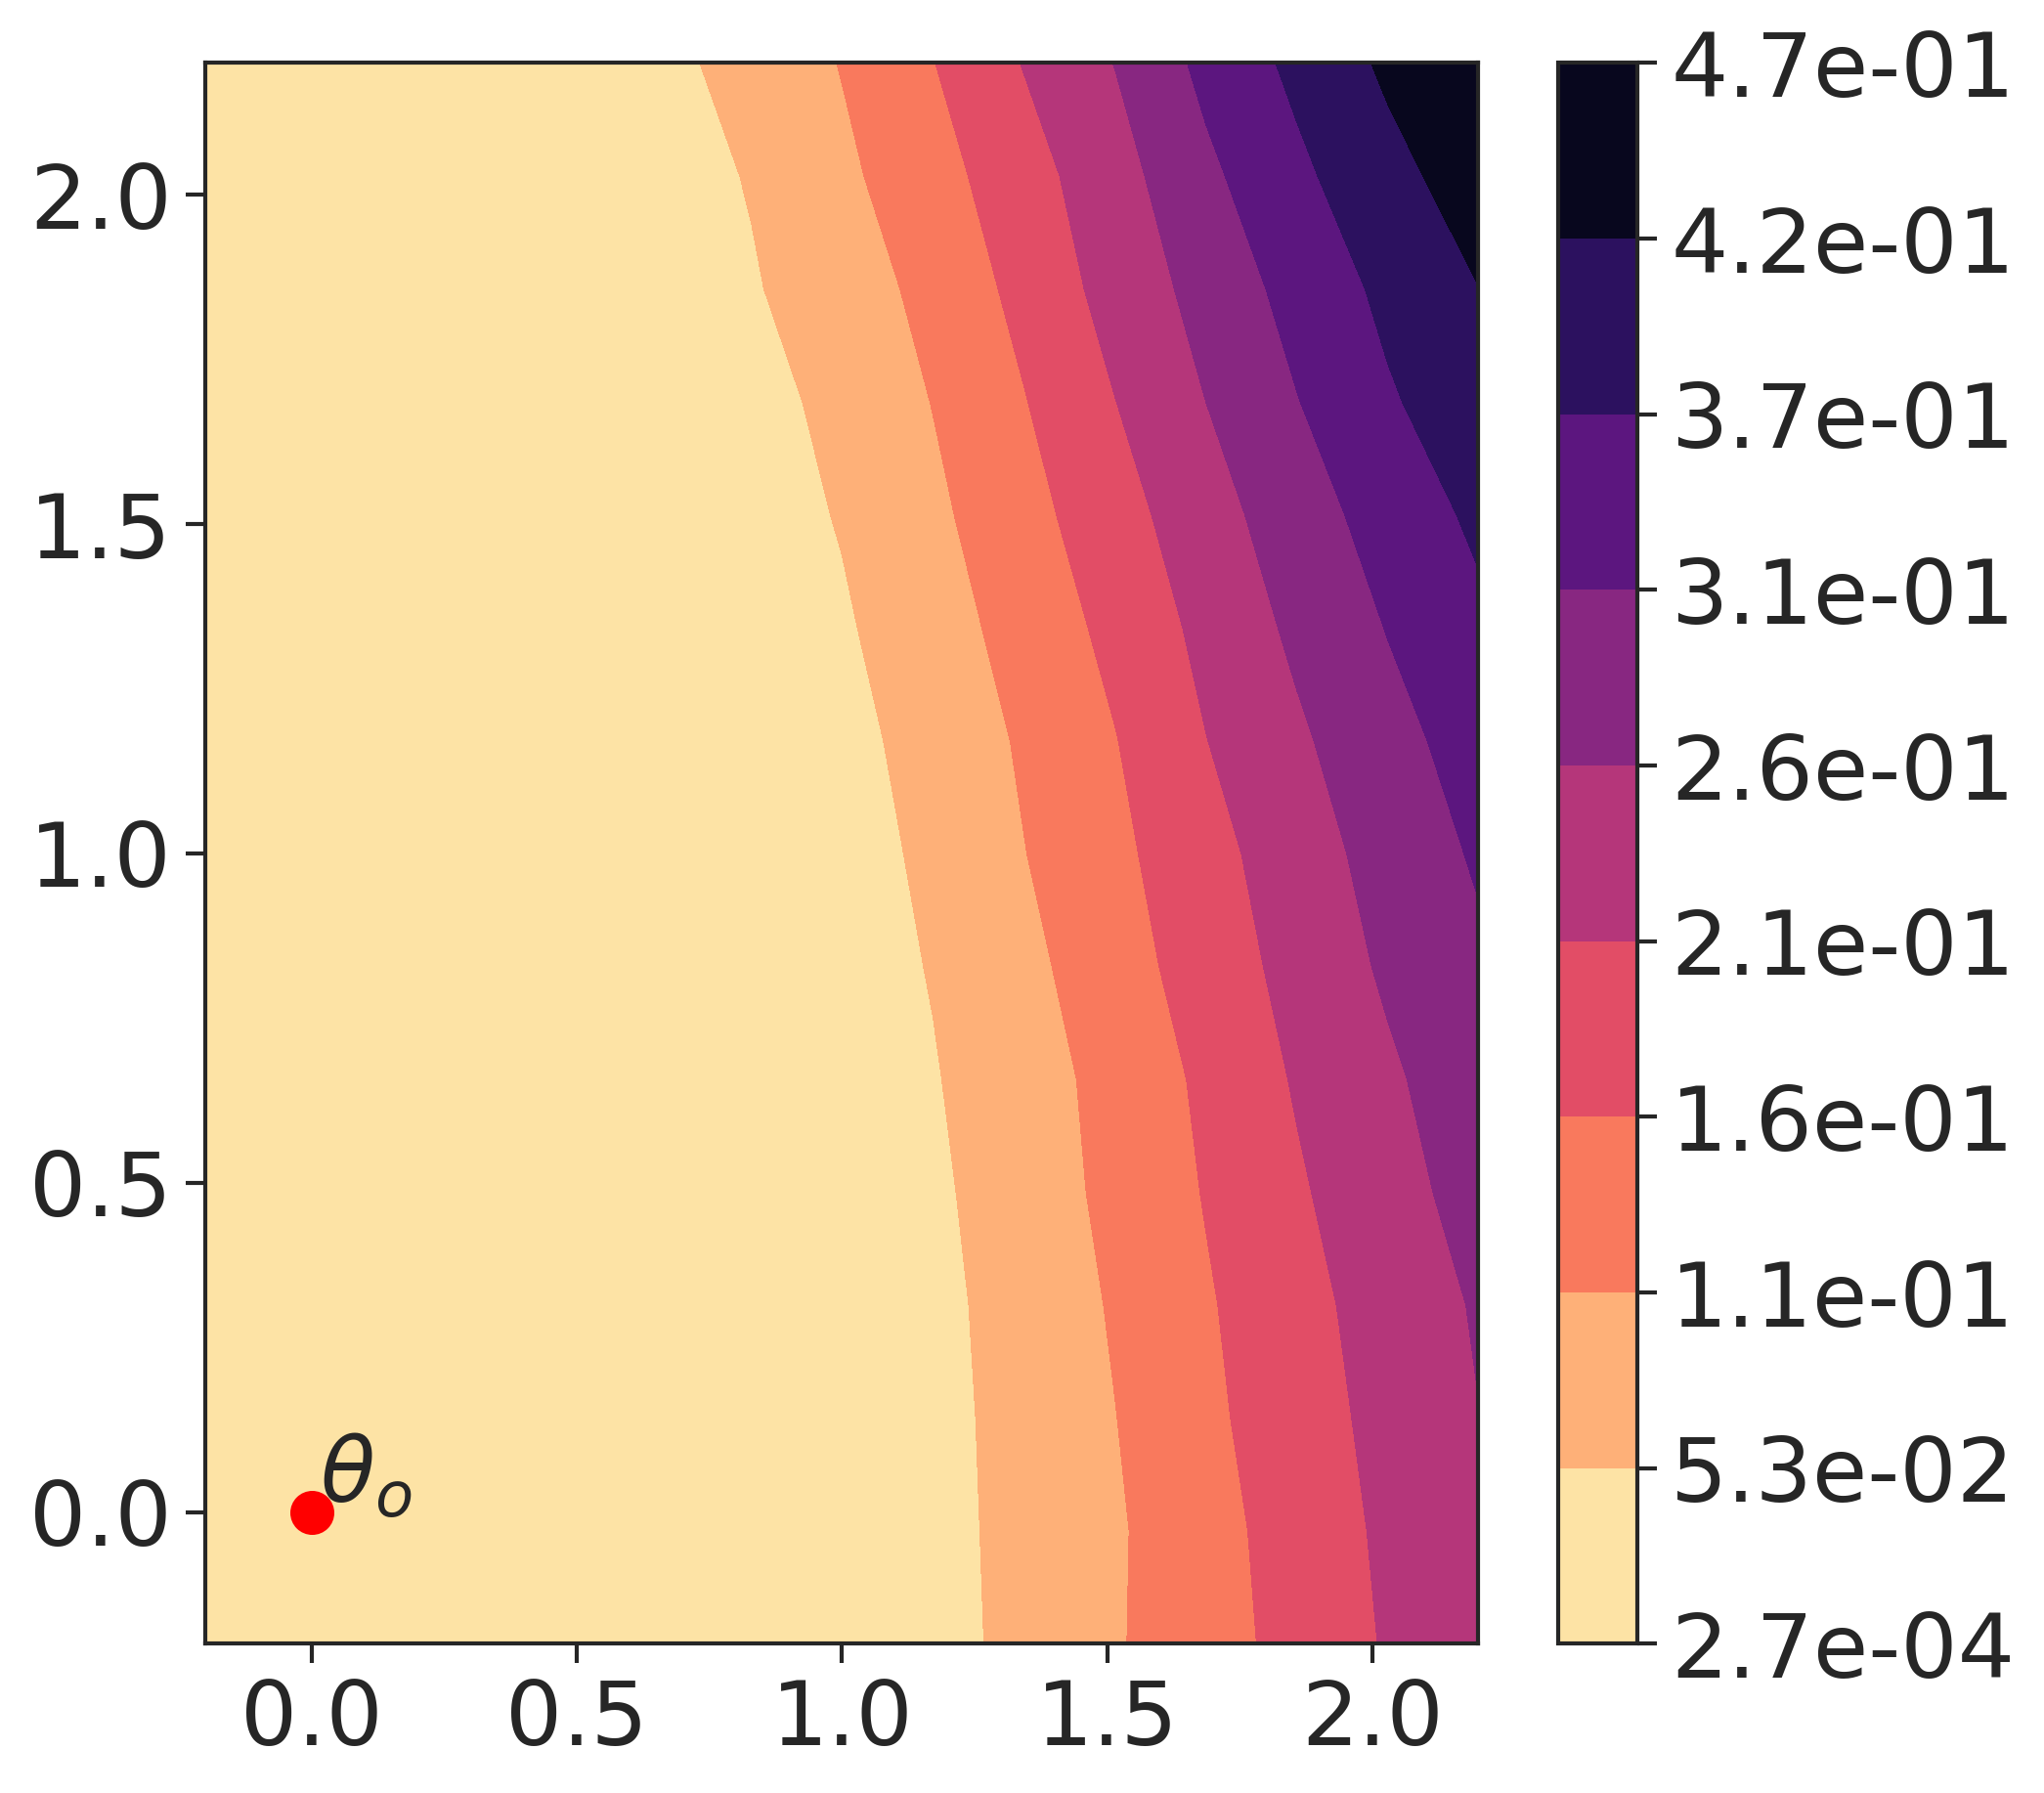

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, ScalarFormatter, FuncFormatter, ScalarFormatter
# Set your seaborn and matplotlib configuration as before
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Your predefined styling
sns.set(style="ticks")
sns.set_context(
    "paper",
    rc={
        "lines.linewidth": 2.5,
        "xtick.labelsize": 22,
        "ytick.labelsize": 22,
        "lines.markersize": 15,
        "legend.fontsize": 24,
        "axes.labelsize": 22,
        "axes.titlesize": 22,
        "legend.handlelength": 1,
        "legend.handleheight": 1,
    },
)

for key in res:
    res[key] = np.array(res[key])

values = res["losses"]
grid = res["grid"]

# Adjusting for non-latex backend
# rc("text", usetex=False)
# matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"

# Create a large number of levels for a smoother gradient
min_value, max_value = np.min(values), np.max(values)
num_levels = 10  # Use a high number for smooth gradients
levels = np.linspace(min_value, max_value, num_levels)

# Create the contour plot with the specified levels
plt.figure(figsize=(7, 7), dpi=300)
contourf = plt.contourf(
    grid[:, :, 0], grid[:, :, 1], values, 
    levels=levels, 
    cmap="magma_r", 
    norm=Normalize(min_value, max_value)  # Normalization based on your data
)
plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().yaxis.set_major_locator(MultipleLocator(0.5))

# Add colorbar with scientific formatting
colorbar = plt.colorbar(contourf)
# Set the formatter for scientific notation
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))
# colorbar.ax.yaxis.set_major_formatter(formatter)

def scientific_formatter(num, pos):
    return f"{num:.1e}"

colorbar.formatter = FuncFormatter(scientific_formatter)
colorbar.update_ticks()

offset_text = colorbar.ax.yaxis.get_offset_text()
offset_text.set_position((5, 0.1))  # You can adjust these values as needed
offset_text.set_verticalalignment('bottom')  # Align it to the bottom of the axis top
# Add your scatter point and text as before
coord = [0, 0]
plt.scatter(*coord, c="red", marker="o", s=100)
plt.text(coord[0] + 0.015, coord[1] + 0.015, r'$\theta_o$', fontsize=22)

# Show the plot
plt.show()


# SalUn

In [3]:
train_loader, val_loader, test_loader = get_dataloader(args)
remain_train_loader, unlearn_train_loader = split_2_remain_unlearn(args, train_loader)
remain_val_loader, unlearn_val_loader = split_2_remain_unlearn(args, val_loader)
remain_test_loader, unlearn_test_loader = split_2_remain_unlearn(args, test_loader)

remain_class = np.setdiff1d(np.arange(args.num_classes), args.unlearn_class)
arxiv_name = 'original_model_12-20-05-11'

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# create saliency map
def save_gradient_ratio(unlearn_train_loader, model, criterion, args, seed):
    optimizer = torch.optim.SGD(
        model.parameters(),
        args.unlearn_lr,
        momentum=args.momentum,
        weight_decay=args.weight_decay,
    )
    gradients = {}
    model.eval()
    for name, param in model.named_parameters():
        gradients[name] = 0

    for i, (image, target) in enumerate(unlearn_train_loader):
        image = image.cuda()
        target = target.cuda()

        # compute output
        output_clean = model(image)
        loss = - criterion(output_clean, target)

        optimizer.zero_grad()
        loss.backward()

        with torch.no_grad():
            for name, param in model.named_parameters():
                if param.grad is not None:
                    gradients[name] += param.grad.data

    with torch.no_grad():
        for name in gradients:
            gradients[name] = torch.abs_(gradients[name])

    threshold_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    for i in threshold_list:
        print(i)
        sorted_dict_positions = {}
        hard_dict = {}

        # Concatenate all tensors into a single tensor
        all_elements = - torch.cat([tensor.flatten() for tensor in gradients.values()])

        # Calculate the threshold index for the top 10% elements
        threshold_index = int(len(all_elements) * i)

        # Calculate positions of all elements
        positions = torch.argsort(all_elements)
        ranks = torch.argsort(positions)

        start_index = 0
        for key, tensor in gradients.items():
            num_elements = tensor.numel()
            # tensor_positions = positions[start_index: start_index + num_elements]
            tensor_ranks = ranks[start_index : start_index + num_elements]

            sorted_positions = tensor_ranks.reshape(tensor.shape)
            sorted_dict_positions[key] = sorted_positions

            # Set the corresponding elements to 1
            threshold_tensor = torch.zeros_like(tensor_ranks)
            threshold_tensor[tensor_ranks < threshold_index] = 1
            threshold_tensor = threshold_tensor.reshape(tensor.shape)
            hard_dict[key] = threshold_tensor
            start_index += num_elements

        torch.save(hard_dict, f'./save/{args.dataset}/{args.model_name}/mask_threshold_{seed}_{i}.pt')


args.unlearn_lr=0.01
args.momentum=0.9
args.weight_decay=5e-4
criterion = nn.CrossEntropyLoss()

for i in range(3):
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    save_gradient_ratio(unlearn_train_loader, model, criterion, args, args.seeds[i])

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


In [7]:
from agents.svc_mia import SVC_MIA
indice = remain_train_loader.sampler.indices
neg_size = len(test_loader.sampler) + len(val_loader.sampler.indices)
balanced_indice = np.random.choice(indice, size=neg_size, replace=False)
balanced_sampler = torch.utils.data.SubsetRandomSampler(balanced_indice)
balanced_train_loader = torch.utils.data.DataLoader(remain_train_loader.dataset,
                                                    batch_size=args.batch_size,
                                                    sampler=balanced_sampler)

threshold = 0.8
MIA_acc = np.zeros(3)
for i in range(3):
    print("======="*50)
    mask = torch.load(f'./save/{args.dataset}/{args.model_name}/mask_threshold_{args.seeds[i]}_{threshold}.pt')
    model = get_model(args)
    model.load_state_dict(torch.load(f'./save/{args.dataset}/{args.model_name}/{arxiv_name}_{args.seeds[i]}.pth'))
    sgd_mr_model = deepcopy(model)
    test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)
    optimizer = torch.optim.SGD(sgd_mr_model.parameters(), lr=0.0005)
    sgd_mr_model.train()
    for m in sgd_mr_model.modules():
        if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
            m.eval()

    for ep in range(5):
        for batch, (x, y) in enumerate(unlearn_train_loader):
            x = x.cuda()
            y = torch.from_numpy(np.random.choice(remain_class, size=x.shape[0])).cuda()
            pred_y = sgd_mr_model(x)
            loss = criterion(pred_y, y)
            optimizer.zero_grad()
            loss.backward()
            for name, param in sgd_mr_model.named_parameters():
                if param.grad is not None:
                    param.grad *= mask[name]
            optimizer.step()
        print('[train] epoch {}, batch {}, loss {}'.format(ep, batch, loss))
        test_by_class(sgd_mr_model, test_loader, i=args.unlearn_class)

    MIA_acc[i] =  SVC_MIA(shadow_train=balanced_train_loader, 
            target_train=None, 
            target_test=unlearn_train_loader,
            shadow_test=test_loader, 
            model=sgd_mr_model)
print(f'MIA acc: {MIA_acc.mean():.2f} \pm {MIA_acc.std():.2f}')

0.9100, 0.8300, 0.6100, 0.6500, 0.6700, 0.7900, 0.8200, 0.7700, 0.9000, 0.8600, 0.5200, 0.5000, 0.7900, 0.7400, 0.7300, 0.7600, 0.7500, 0.9000, 0.5900, [0.7100], 0.8600, 0.9000, 0.7700, 0.8000, 0.8200, 0.5700, 0.7700, 0.6100, [0.8100], 0.7500, 0.6600, 0.7500, [0.6900], 0.6700, 0.8200, 0.4400, 0.8600, 0.7600, 0.7300, 0.8900, 0.6300, 0.9000, 0.8000, 0.8400, 0.5100, 0.6400, 0.5100, 0.7100, 0.9400, 0.8700, 0.5600, [0.7300], 0.6600, 0.9100, 0.8100, 0.5200, 0.8700, 0.8200, 0.8700, 0.7000, 0.8900, 0.7500, 0.7900, 0.7000, 0.5900, [0.6200], 0.8300, [0.7100], 0.9400, 0.8300, 0.7500, 0.7900, 0.4700, 0.6400, 0.5800, 0.9000, 0.9200, 0.7000, 0.7100, 0.8200, [0.6000], 0.7700, 0.9200, 0.7200, 0.6700, [0.8500], [0.7500], 0.9000, 0.8500, 0.8900, 0.8400, 0.8400, 0.6700, 0.5600, 0.9300, 0.7400, 0.6700, [0.8100], 0.5500, 0.7100, Acc_f: 0.7280, Acc_r: 0.7491
[train] epoch 0, batch 8, loss 4.909927845001221
0.6100, 0.4600, 0.1900, 0.6000, 0.4600, 0.3800, 0.6300, 0.6700, 0.7500, 0.7800, 0.1800, 0.1500, 0.5600

In [8]:
Acc_r = 100*np.array([0.4158,  0.4634,  0.3762])
Acc_f = 100*np.array([0.0690,  0.0700,  0.0400])

print(f'SalUn Acc_f: {Acc_f.mean():.2f} \pm {Acc_f.std():.2f}')
print(f'SalUn Acc_r: {Acc_r.mean():.2f} \pm {Acc_r.std():.2f}')

SalUn Acc_f: 5.97 \pm 1.39
SalUn Acc_r: 41.85 \pm 3.56
